In [2]:
import cv2
import random
import time
import numpy as np
from scipy import misc

from matplotlib import pyplot as plt
from scipy import misc
%matplotlib inline
plt.style.use('ggplot')
import os
import sys
sys.path.append('../common/')
import utils

In [3]:
import pickle

In [4]:
import pickle
with open('./xy.pkl','rb') as whdl:
    (IM_train,y_train,IM_test) = pickle.load(whdl)

# 查看和分析数据

In [5]:
len(IM_train),len(y_train)

(58512, 58512)

In [6]:
np.mean(IM_train[0], axis=2) # 100, 100, 3 求3个色道矩阵的均值

array([[  4.        ,   5.        ,  11.33333333, ...,  41.        ,
         42.        ,  43.66666667],
       [  2.66666667,   4.66666667,  15.66666667, ...,  39.        ,
         39.        ,  38.66666667],
       [  1.33333333,   4.        ,  21.        , ...,  40.        ,
         38.        ,  36.66666667],
       ...,
       [  1.        ,   0.33333333,  37.66666667, ..., 121.        ,
        108.66666667, 109.33333333],
       [  1.        ,   0.33333333,  37.66666667, ..., 127.33333333,
        124.66666667, 124.33333333],
       [  1.        ,   0.33333333,  37.66666667, ..., 122.        ,
        129.66666667, 129.33333333]])

In [7]:
def translate(image, x, y):
    M = np.float32([[1, 0, x], [0, 1, y]])
    # https://docs.opencv.org/3.4/da/d6e/tutorial_py_geometric_transformations.html
    shifted = cv2.warpAffine(image, M, (image.shape[1], image.shape[0]))# image.shape[1]=cols image.shape[0]=rows
    return shifted

def calculate_histogram(array,weights,bins=9):
    bins_range = (-75, 75)
    # https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.histogram.html
    hist,_ = np.histogram(array,bins=bins,range=bins_range,weights=weights)
    return hist

/Users/s4467575/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/Users/s4467575/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in true_divide
/Users/s4467575/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in arctan
/Users/s4467575/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/s4467575/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


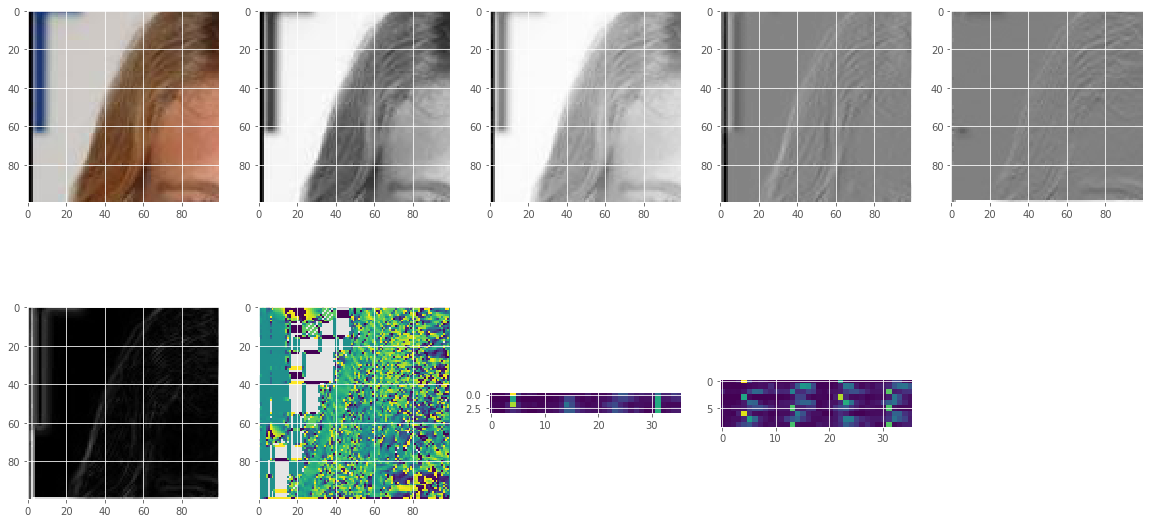

In [6]:
plt.figure(figsize=(20,10))

sample_image = IM_train[0]
plt.subplot(2,5,1)
plt.imshow(sample_image)


# STEP 1 convert to gray
sample_image = cv2.cvtColor(sample_image,cv2.COLOR_RGB2GRAY)
plt.subplot(2,5,2)
plt.imshow(sample_image,cmap='gray')
# 老师课上讲的：也可以这么做：plt.imshow(np.mean(sample_image, axis=2), cmap='gray')


# STEP 2 normalize 归一化
sample_image = sample_image ** 0.5
plt.subplot(2,5,3)
plt.imshow(sample_image,cmap='gray')

# STEP 3 calculate GX,GY
GX = translate(sample_image,1,0) - translate(sample_image,-1,0) # 取巧的方式计算dx: （向左平移一个单位）- （向右平移 一个单位）
plt.subplot(2,5,4)
plt.imshow(GX,cmap='gray')

GY = translate(sample_image,0,1) - translate(sample_image,0,-1)
plt.subplot(2,5,5)
plt.imshow(GY,cmap='gray')

# STEP 4 calculate DELTA G and angle
delta_G = np.sqrt(GX ** 2 + GY ** 2)
plt.subplot(2,5,6)
plt.imshow(delta_G,cmap='gray')

angle = np.arctan(GY / GX) / np.pi * 180
plt.subplot(2,5,7)
plt.imshow(angle)

delta_G[angle == 0] = 0

def calculate_histogram(array,weights,bins=9):
    bins_range = (-75, 75)
    hist,_ = np.histogram(array,bins=bins,range=bins_range,weights=weights)
    return hist

# step 5 calcalute features
features = np.zeros((4,4,9))
for i in range(0,100,25):
    for j in range(0,100,25):
        # PPT 里面是 8*8，这里为了方便，其实是25 * 25
        features[i // 25,j // 25] = calculate_histogram(angle[i:i + 25,j:j + 25],delta_G[i:i + 25,j:j + 25])
        
plt.subplot(2,5,8)
plt.imshow(features.reshape(4,36))

# step 6 local normalize
one_feature = []
for i in range(3):
    for j in range(3):
        mat_norm = features[i:i + 2,j:j + 2]
        mag = np.linalg.norm(mat_norm)
        arr_list = (mat_norm / mag).flatten().tolist()
        one_feature += arr_list
plt.subplot(2,5,9)
plt.imshow(np.asarray(one_feature).reshape(9,-1))

In [94]:
len(one_feature)

324

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe7818edd8>]], dtype=object)

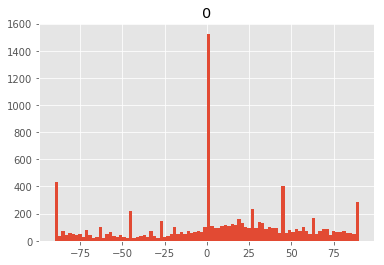

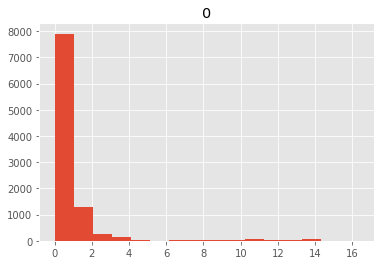

In [95]:
# import pandas as pd
pd.DataFrame(angle.reshape(-1)).hist(bins=90)
pd.DataFrame(delta_G.reshape(-1)).hist(bins=16)

In [103]:

def extrace_feature(sample_image):
    sample_image = cv2.cvtColor(sample_image,cv2.COLOR_RGB2GRAY)

    # STEP 2 normalize/ 归一化
    sample_image = sample_image ** 0.5

    # STEP 3 calculate GX,GY
    GX = translate(sample_image,1,0) - translate(sample_image,-1,0)
    GY = translate(sample_image,0,1) - translate(sample_image,0,-1)

    # STEP 4 calculate DELTA G and angle
    delta_G = np.sqrt(GX ** 2 + GY ** 2)
    angle = np.arctan(GY / GX) / np.pi * 180
    delta_G[angle == 0] = 0

    # step 5 calcalute features
    features = np.zeros((4,4,9))
    for i in range(0,100,25):
        for j in range(0,100,25):
            features[i // 25,j // 25] = calculate_histogram(angle[i:i + 25,j:j + 25],delta_G[i:i + 25,j:j + 25])

    # step 6 local normalize
    one_feature = []
    for i in range(3):
        for j in range(3):
            mat_norm = features[i:i + 2,j:j + 2] # 2 * 2 * 9
            mag = np.linalg.norm(mat_norm)
            arr_list = (mat_norm / mag).flatten().tolist() # flatten == reshape (-1).. 2 2 9-> 36
            one_feature += arr_list
    return one_feature

/data/zonghua/envs/icybee/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/data/zonghua/envs/icybee/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/data/zonghua/envs/icybee/lib/python3.5/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/data/zonghua/envs/icybee/lib/python3.5/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


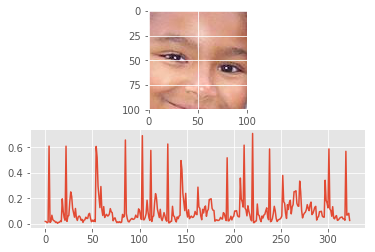

In [105]:
#histr = cv2.calcHist([IM_train[0]],[1],None,[256],[0,256])

plt.subplot(2,1,1)
plt.imshow(IM_train[188])
plt.subplot(2,1,2)
plt.plot(extrace_feature(IM_train[188]))

In [107]:
np.where(np.asarray(y_train)==1)[0][:10]

array([ 34,  39,  40, 145, 150, 151, 188, 192, 193, 194])

In [111]:
from collections import Counter

In [115]:
Counter(y_train)

Counter({0: 55755, 1: 2757})

# Training Step

In [118]:

pb = utils.ProgressBar(worksum=len(IM_train))
pb.startjob()
features = []
targets = []
for one_image,one_target in zip(IM_train,y_train):
    one_feature = []
    if len(one_image.shape) != 3:
        continue
    if one_target == 0 and random.random() > 0.2:
        pb.complete(1)
        continue
    features.append(extrace_feature(one_image))
    targets.append(one_target)
    pb.complete(1)

 0.29 % [>--------------------------------------------------] 168/58512 	 used:0s eta:79 s

/data/zonghua/envs/icybee/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/data/zonghua/envs/icybee/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/data/zonghua/envs/icybee/lib/python3.5/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/data/zonghua/envs/icybee/lib/python3.5/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


 16.84 % [========>------------------------------------------] 9851/58512 	 used:10s eta:51 s

/data/zonghua/envs/icybee/lib/python3.5/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


 99.76 % [=================================================>-] 58371/58512 	 used:63s eta:0 s

In [119]:
len(features),len(targets)

(13892, 13892)

In [120]:
train_x,val_x = features[:-2000], features[-2000:]
train_y,val_y = targets[:-2000], targets[-2000:]

In [122]:
import sklearn
from sklearn.svm import SVC

In [130]:
svm = SVC(probability=True)

In [131]:
train_x = np.nan_to_num(train_x,0)

In [132]:
svm_model = svm.fit(train_x,train_y)

In [133]:
val_x = np.nan_to_num(val_x,0)

In [134]:
val_pred = svm_model.predict_proba(val_x)[:,1]

In [135]:
val_pred

array([  4.77900850e-05,   3.34704086e-04,   3.06312798e-03, ...,
         3.74561209e-03,   6.79491428e-01,   8.48710887e-02])

In [136]:
from sklearn import metrics

In [137]:
 fpr, tpr, thresholds = metrics.roc_curve(val_y, val_pred, pos_label = 1)

In [138]:
metrics.auc(fpr, tpr)

0.95943759433117592

# Testing Step

/data/zonghua/envs/icybee/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/data/zonghua/envs/icybee/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/data/zonghua/envs/icybee/lib/python3.5/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/data/zonghua/envs/icybee/lib/python3.5/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


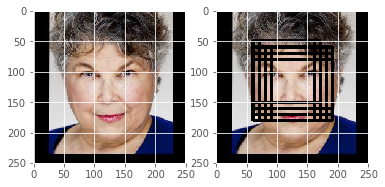

In [176]:

sample_image = np.copy(IM_test[23])
plt.subplot(1,2,1)
plt.imshow(sample_image)
for i in range(0,250 - 100,10):
    for j in range(0,250 - 100,10):
        one_feature = extrace_feature(sample_image[i:i + 100,j:j + 100])
        one_feature = np.nan_to_num(one_feature,0)
        result = svm_model.predict_proba([one_feature])
        #print(result)
        if result[0][1] > 0.5:
            cv2.rectangle(sample_image,(i,j),(i + 100,j + 100),(0,0,0),3)
plt.subplot(1,2,2)
plt.imshow(sample_image)

In [117]:
result

array([[ 0.99784405,  0.00215595]])